# K-Nearst Neighboor Processing v.0.1.3
`Authorship: TFL, RS and CL`

# Importing functions

In [5]:
import pandas as pd
import re
import numpy as np
import os
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
from collections import Counter
import glob
import matplotlib.pyplot as plt
import subprocess
from Bio import SeqIO
from sklearn.neighbors import KNeighborsClassifier
from Bio.SeqUtils import GC
import time
from pyteomics import mzxml
import rpy2
import csv
from multiprocessing import Pool
import pickle
%load_ext rpy2.ipython
%matplotlib inline

ModuleNotFoundError: No module named 'bs4'

In [ ]:
def get_bigscape_df(input_file):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(" ","_",x), inplace=True)
    bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

def get_neighbors(target,dataframe,column1,column2):
    '''This function parses a network-like dataframe (e.g.edges_df) looking for rows where the indicated columns 
    (e.g. A and B) have the target (e.g. a MS index from edges_df), subsetting this dataframe. Last, it outputs a 
    list of neighbors (MS indexes that interact with the target).
    ''' 
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    '''This function convert a list of group of nodes into edges
    Script adapted from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements/4842783
    '''
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    '''This function generate a graph using a list of group of nodes and the edges create with the function to_edges()
    Script adapted from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements/4842783
    '''
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary,column1,column2,column3):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file):
    bigscape_df = get_bigscape_df(input_file)
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict,'Clustername_1','Clustername_2','Raw_distance')
    return bigscape_df,gcf_dict

In [ ]:
def get_pre_training_df(bigscape_df,bigscape_dict,strain_list,bigscape_bgcs):
    start_time = time.time()
    training_df = pd.DataFrame(columns=strain_list, index=range(0,len(bigscape_bgcs)))
    index_row = 0
    row_names = []
    for gcf in bigscape_dict:
        for cluster in bigscape_dict[gcf]:
            row_names.append(cluster)
            temp_dict = {}
            self = cluster.split("_")[0]
            temp_dict[self] = [1]
            temp_df = bigscape_df[bigscape_df.Clustername_1.str.contains(cluster) | 
                                  bigscape_df.Clustername_2.str.contains(cluster)]
            for i,r in temp_df.iterrows():
                if temp_df.Clustername_1.loc[i] == cluster:
                    target = temp_df.Clustername_2.loc[i]
                    target = str(target).split("_")[0]
                    if target not in temp_dict:
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
                else:
                    target = temp_df.Clustername_1.loc[i]
                    target = str(target).split("_")[0]
                    if target not in temp_dict.keys():
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
            for key in temp_dict:
                if len(temp_dict[key]) > 1:
                    new_value = max(temp_dict[key])
                    temp_dict[key] = new_value
                else:
                    temp_dict[key] = temp_dict[key][0]
            temp_dict["label"] = gcf
            training_df.loc[index_row] = pd.Series(temp_dict)
            index_row += 1
    training_df.fillna(0,inplace=True)
    print('\n' + "--- %s seconds ---" %(time.time()-start_time))
    return training_df,row_names

In [3]:
def get_BGC_features(filepath):
    m = re.search(r'^BGC(.*)',os.path.basename(filepath))
    if m:
        gb_record = next(SeqIO.parse(open(filepath,"r"), "genbank"))
        bgc_name = os.path.splitext(os.path.basename(filepath))[0]
        gc_content = GC(str(gb_record.seq))
        size = 0
        for feature in gb_record.features:
            if feature.type == "source":
                size = re.search(r'(\d*):(\d*)(.*)','%s'%feature.location).group(2)
        bgc_type = "MIBiG"
        if size != 0:
            line = [str(bgc_name), size, str(bgc_type), round(gc_content,2)]
        else:
            print("Error at sample %s"%m.group())
        return line
    else:
        gb_record = SeqIO.read(open(filepath,"r"), "genbank")
        bgc_name = os.path.splitext(os.path.basename(filepath))[0]
        for feature in gb_record.features:
            if feature.type == "cluster":
                gc_content = GC(str(gb_record.seq))
                size = re.search(r'(\d*):(\d*)(.*)','%s'%feature.location).group(2)
                bgc_type = feature.qualifiers['product'][0]
                line = [str(bgc_name), size, str(bgc_type), round(gc_content,2)]
                return line
    
def get_features_df(input_folder):
    start_time = time.time()
    lines = []
    input_list = glob.glob("%s*.gbk"%input_folder)
    for item in input_list:
        line = get_BGC_features(item)
        lines.append(line)
    labels = ["name","size","type","gc"]
    df = pd.DataFrame(lines, columns=labels)
    print('\n' + "--- %s seconds ---" %(time.time()-start_time))
    return df

# Loading bigscape and taxonomy dictionaries

Inputs: all complete BGCs from Cyanobiome,

In [4]:
# big-scape run on Cyanobiome complete BGCs + all NCBI
# we selected 4 published genomes as the testing set (Moorea 3L, Moorea PNG, Moorea PAL and Leptolyngbya ISB)

start_time = time.time()
testing_strains = ["AEPQ01","MKZS01","PALPB","ISBONT"]

input_bigscape_net = "/Users/tiagoferreiraleao/Dropbox/cyanet/bigscape/output_all-2/bigscape_all_c080.txt" #for comp. + incomp.
# input_bigscape_net = "/home/tiago/Desktop/cyanet/bigscape/output_complete1/bigscape_all_c080.txt" #for comp. only

bigscape_df,bigscape_dict = main_get_families(input_bigscape_net)

# to convert from distance to similarity:
bigscape_df["Raw_distance"] = 1-bigscape_df["Raw_distance"]

print('\n' + "--- %s minutes ---" %((time.time()-start_time)/60))

NameError: name 'time' is not defined

# Creating BGC affinity training dataframe

In [8]:
bgcs_list = [item for sublist in bigscape_dict.values() for item in sublist]
strain_list = []

for item in bgcs_list:
    if "BGC" not in item:
        strain_list.append(item.split("_")[0])
strain_list = list(np.unique(strain_list))
strain_list.append("label")
    
affinity_df,affinity_bgcs = get_pre_training_df(bigscape_df,bigscape_dict,strain_list,bgcs_list)

affinity_df.shape


--- 2296.65801692 seconds ---


(5945, 523)

In [9]:
#removing unnecessary MIBiG rows
affinity_df["bgc"] = affinity_bgcs

mibig_df = affinity_df[affinity_df["bgc"].str.match('BGC')]
affinity_df = affinity_df[~affinity_df["bgc"].str.match('BGC')]

mibig_df = mibig_df.drop(columns=["bgc"],axis=1).reset_index(drop=True)
affinity_df = affinity_df.drop(columns=["bgc"],axis=1).reset_index(drop=True)

affinity_df.shape,mibig_df.shape

((4539, 523), (1406, 523))

In [11]:
affinity_df.to_csv("./cyanobiome/tables/affinity_df-TFL190403.txt")

In [14]:
pickle.dump( affinity_bgcs, open( "./cyanobiome/tables/affinity_bgcs-TFL190403.txt", "wb" ) )

# Running machine learning test 1: distance-patterns, all cyano vs 4 best

**Separating training from testing (52 BGCs from 3L and PNG) samples**

In [10]:
s = affinity_df[testing_strains]

s = s[s == 1].dropna(how="all")

indexes_test = s.index

training_df = affinity_df.drop(affinity_df.index[indexes_test]).reset_index(drop=True)
testing_df = affinity_df.loc[indexes_test].reset_index(drop=True)

#for removig self columns
training_df = training_df.drop(testing_strains,axis=1).reset_index(drop=True)
testing_df = testing_df.drop(testing_strains,axis=1).reset_index(drop=True)

print affinity_df.shape,training_df.shape,testing_df.shape

(4489, 522) (4370, 518) (119, 518)


**Fitting the training data**

In [11]:
X_div = training_df.drop("label", axis=1)
X_div.shape

(4370, 517)

In [12]:
y_div = training_df["label"]
y_div.shape

(4370,)

In [13]:
clf = KNeighborsClassifier(n_neighbors=5) #68.90% if k=25

clf.fit(X_div,y_div)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

**Testing reference strains**

In [14]:
y_pred = clf.predict(testing_df.drop("label",axis=1))

positives = 0
pos_list = []
neg_list = []

for i,v in enumerate(y_pred):
    if v == testing_df["label"].loc[i]:
        positives += 1
        pos_list.append(v)
    else:
        neg_list.append(v)

ratio = float(positives)/float(len(y_pred))*100
print "\n","Success rate of %s out of %s, %f percent"%(positives,len(y_pred),ratio)


Success rate of 94 out of 119, 78.991597 percent


| <p align="left"> Testing vs training | <p align="left"> total_cols | <p align="left"> n_cols | <p align="left"> test_rows | <p align="left"> train_rows | <p align="left"> precision |
|------------- |:-------------:| -----:|
|<p align="left">`sim[all(3L,PNG,PAL,ISB)]` vs `sim[comp34%(NCBI+Cyanobiome+self+MIBiG)]` | 364 | 58 | 84 | 2724 | 46.42%
|<p align="left">`sim[all(3L,PNG,PAL,ISB)]` vs `sim[comp34%(NCBI+Cyanobiome+self)]` | 364 | 58 | 84 | 1319 | 51.19%
|<p align="left">`sim[all(3L,PNG,PAL,ISB)]` vs `sim[comp34%(NCBI+Cyanobiome)]` | 360 | 54 | 84 | 1319 |45.23%
|<p align="left">`sim[all(3L,PNG,PAL,ISB)]` vs `sim[comp34%(NCBI+Cyanobiome+self)]` + `type` | 361 | 58 | 84 | 1319 | **52.38%**
|
|<p align="left">`sim[all(3L,PNG,PAL,ISB)]` vs `sim[comp34%+inc66%(NCBI+Cyanobiome+self+MIBiG)]` | 522 | 121 | 119 | 5776 | 72.26%
|<p align="left">`sim[all(3L,PNG,PAL,ISB)]` vs `sim[comp34%+inc66%(NCBI+Cyanobiome+self)]` | 522 | 121 | 119 | 4370 | 78.99%
|<p align="left">`sim[all(3L,PNG,PAL,ISB)]` vs `sim[comp34%+inc66%(NCBI+Cyanobiome)]` | 518 | 117 | 119 | 4370 |**78.99%**
|<p align="left">`sim[all(3L,PNG,PAL,ISB)]` vs `sim[comp34%+inc66%(NCBI+Cyanobiome)]`+`type` | 519 | 118 | 119 | 4370 |???%

# Test2: sub-setting for genome with MS2

In [15]:
bgcs_list = [item for sublist in bigscape_dict.values() for item in sublist]
strain_list = []

for item in bgcs_list:
    if "BGC" not in item:
        strain_list.append(item.split("_")[0])
strain_list = list(np.unique(strain_list))
strain_list.append("label")
    
affinity_df,affinity_bgcs = get_pre_training_df(bigscape_df,bigscape_dict,strain_list,bgcs_list)

affinity_df.shape


--- 1488.70598507 seconds ---


(5895, 522)

In [16]:
#separating MIBiG rows
affinity_df["bgc"] = affinity_bgcs

mibig_df = affinity_df[affinity_df["bgc"].str.match('BGC')]
affinity_df = affinity_df[~affinity_df["bgc"].str.match('BGC')]

mibig_df = mibig_df.drop(columns=["bgc"],axis=1).reset_index(drop=True)
affinity_df = affinity_df.drop(columns=["bgc"],axis=1).reset_index(drop=True)

affinity_df.shape,mibig_df.shape

((4489, 522), (1406, 522))

In [17]:
master_df = pd.read_csv("./tables/master_dataframe-TFL180830.csv",sep="\t")
df2 = master_df[master_df.lcms_file.astype(str) != "nan"]
# df2 = df2[df2.fraction == "Crude"]

genome_list = []

for i,r in df2.iterrows():
    genome = df2.genomeID.loc[i]
    if genome in list(affinity_df.columns):
        if genome not in genome_list:
            genome_list.append(genome)

print len(genome_list)

61


In [18]:
from operator import sub

exclude_list = [item for item in list(affinity_df.columns) if item not in genome_list][:-1] #keeping "label" (-1)

print len(exclude_list)

460


In [19]:
s = affinity_df[testing_strains]

s = s[s == 1].dropna(how="all")

indexes_test = s.index

len(indexes_test)

119

In [20]:
training2_df = affinity_df.drop(affinity_df.index[indexes_test]).reset_index(drop=True)
old_cols = training2_df.label
training2_df = training2_df.drop("label", axis=1)
training2_df = training2_df[genome_list]
training2_df = training2_df[(training2_df.T != 0).any()]
new_col = []
for i,r in training2_df.iterrows():
    new_col.append(old_cols[i])
training2_df["label"] = new_col
training2_df = training2_df.reset_index(drop=True)

training2_df.shape

(2453, 62)

In [21]:
testing2_df = affinity_df.loc[indexes_test].reset_index(drop=True)
old_cols = testing2_df.label
testing2_df = testing2_df.drop("label", axis=1)
testing2_df = testing2_df[genome_list]
testing2_df = testing2_df[(testing2_df.T != 0).any()]
new_col = []
for i,r in testing2_df.iterrows():
    new_col.append(old_cols[i])
testing2_df["label"] = new_col
testing2_df = testing2_df.reset_index(drop=True)

testing2_df.shape

(111, 62)

In [22]:
X_div = training2_df.drop("label", axis=1)
X_div.shape

(2453, 61)

In [23]:
y_div = training2_df["label"]
y_div.shape

(2453,)

In [24]:
clf = KNeighborsClassifier(n_neighbors=5) # 57.65% with k=25

clf.fit(X_div,y_div)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [25]:
y_pred = clf.predict(testing2_df.drop("label",axis=1))

positives = 0
pos_list = []
neg_list = []

for i,v in enumerate(y_pred):
    if v == testing2_df["label"].loc[i]:
        positives += 1
        pos_list.append(v)
    else:
        neg_list.append(v)

ratio = float(positives)/float(len(y_pred))*100
print "\n","Success rate of %s out of %s, %f percent"%(positives,len(y_pred),ratio)


Success rate of 86 out of 111, 77.477477 percent


-----

# Test3: gene vs MS2

In [26]:
ispec_mat = pd.read_csv("./tables/mass-affinity_df_SUM_BY_FRACTION-TFL190124.txt",sep="\t")
ispec_mat = ispec_mat[:130]
ispec_mat = ispec_mat.T
ispec_mat.columns = ispec_mat.iloc[0]
ispec_mat = ispec_mat.drop(["genomeID"])

ispec_mat

genomeID,1A2,1A9,1B1,1B6,1B8,1B9,1C1,1C3,1C6,1C8,...,4C2,4C3,4C4,4C5,4C6,4C7,4C8,4C9,4F2,4G2
CCMSLIB00000531501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCMSLIB00000070253,0.631281,0,0,0,0.0579516,0,0,0.175369,0.634515,0,...,0,0,0,0,0,0.636522,0,0.0810232,0,0.153219
CCMSLIB00000478599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCMSLIB00000001595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCMSLIB00000001603,0,0,0,0,0.000212631,0,0,0.00458738,0.00357919,0,...,0,0,0,0,0,0,0,0,0,0
CCMSLIB00000001628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCMSLIB00000006883,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.00242464,0,0
CCMSLIB00000001634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCMSLIB00000001626,0,0,0,0,0,0,0,0.0164565,0,0,...,0,0,0,0,0,0,0,0,0,0
CCMSLIB00000070254,0.715674,0,0,0,0,0,0,0,0.460459,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
networked_cols = []

for item in ispec_mat.columns:
    if item in affinity_df.columns:
        networked_cols.append(item)
        
len(networked_cols)

60

In [28]:
training3_df = affinity_df[networked_cols+["label"]]
training3_df = training3_df[(training3_df.T != 0).any()]

training3_df

,1A2,1B1,1B6,1C3,1D4,1D6,1D9,1E1,1F2,1F9,...,4B7,4B8,4C1,4C2,4C4,4C5,4C7,4C8,4G2,label
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,GCF217
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,GCF217
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,GCF216
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,GCF216
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,GCF215
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,GCF215
6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,GCF214
7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,GCF214
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,GCF214
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.748990,0.0,...,0.0,0.669286,0.0,0.0,0.0,0.0,0.608180,0.0,0.0,GCF210


In [29]:
training3_df = affinity_df[networked_cols+["label"]]
old_cols = training3_df.label
genome_list.remove('4G3') ### BUG HERE!
training3_df = training3_df.drop("label", axis=1)
training3_df = training3_df[genome_list]
training3_df = training3_df[(training3_df.T != 0).any()]
new_col = []
for i,r in training3_df.iterrows():
    new_col.append(old_cols[i])
training3_df["label"] = new_col
training3_df = training3_df.reset_index(drop=True)

training3_df

,3E2,2E1,2E9,2B9,3B5,2E7,1H4,2D2,3C6,3B2,...,2A9,1E1,2G8,1D4,1I4,2H7,3A1,1D9,2B6,label
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,GCF210
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.669286,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,GCF210
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.748627,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,GCF210
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.608180,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,GCF210
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.352857,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,GCF210
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.588834,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,GCF210
6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.669286,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,GCF210
7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.669286,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,GCF210
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.605409,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,GCF210
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.669286,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,GCF210


In [30]:
testing3_df = ispec_mat[networked_cols]
testing3_df = testing3_df.sort_index(axis=1)

In [31]:
testing3_df[:5]

genomeID,1A2,1B1,1B6,1C3,1D4,1D6,1D9,1E1,1F2,1F9,...,4B1,4B7,4B8,4C1,4C2,4C4,4C5,4C7,4C8,4G2
CCMSLIB00000531501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCMSLIB00000070253,0.631281,0,0,0.175369,0,0,0,0.729424,0.772179,0,...,0,0.873004,0.81902,0,0,0,0,0.636522,0,0.153219
CCMSLIB00000478599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCMSLIB00000001595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCMSLIB00000001603,0,0,0,0.00458738,0,0.183386,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
training3_df = training3_df.sort_index(axis=1)

training3_df[:5]

,1A2,1B1,1B6,1C3,1D4,1D6,1D9,1E1,1F2,1F9,...,4B7,4B8,4C1,4C2,4C4,4C5,4C7,4C8,4G2,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.748990,0.0,...,0.0,0.669286,0.0,0.0,0.0,0.0,0.608180,0.0,0.0,GCF210
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.821691,0.0,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.885521,0.0,0.0,GCF210
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.996873,0.0,...,0.0,0.821237,0.0,0.0,0.0,0.0,0.769653,0.0,0.0,GCF210
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.769843,0.0,...,0.0,0.885521,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,GCF210
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.425749,0.0,...,0.0,0.520238,0.0,0.0,0.0,0.0,0.457151,0.0,0.0,GCF210


In [33]:
ispec_mat.shape,testing3_df.shape,training3_df.shape

((39, 130), (39, 60), (2558, 61))

In [34]:
X_div = training3_df.drop("label", axis=1)
X_div.shape

(2558, 60)

In [35]:
y_div = training3_df["label"]
y_div.shape

(2558,)

In [36]:
clf = KNeighborsClassifier(n_neighbors=5) # 57.65% with k=25

clf.fit(X_div,y_div)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [37]:
y_pred = clf.predict(testing3_df)

y_pred

array(['GCF12', 'GCF210', 'GCF12', 'GCF12', 'GCF12', 'GCF4', 'GCF1',
       'GCF12', 'GCF4', 'GCF10', 'GCF56', 'GCF12', 'GCF11', 'GCF11',
       'GCF12', 'GCF12', 'GCF12', 'GCF1', 'GCF56', 'GCF11', 'GCF12',
       'GCF12', 'GCF12', 'GCF1', 'GCF12', 'GCF11', 'GCF1', 'GCF4',
       'GCF10', 'GCF11', 'GCF12', 'GCF11', 'GCF4', 'GCF3', 'GCF1',
       'GCF56', 'GCF10', 'GCF11', 'GCF1'], dtype=object)

In [38]:
testing3_df["label"] = y_pred

testing3_df[:10]

genomeID,1A2,1B1,1B6,1C3,1D4,1D6,1D9,1E1,1F2,1F9,...,4B7,4B8,4C1,4C2,4C4,4C5,4C7,4C8,4G2,label
CCMSLIB00000531501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GCF12
CCMSLIB00000070253,0.631281,0,0,0.175369,0,0,0,0.729424,0.772179,0,...,0.873004,0.81902,0,0,0,0,0.636522,0,0.153219,GCF210
CCMSLIB00000478599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GCF12
CCMSLIB00000001595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GCF12
CCMSLIB00000001603,0,0,0,0.00458738,0,0.183386,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GCF12
CCMSLIB00000001628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GCF4
CCMSLIB00000006883,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GCF1
CCMSLIB00000001634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GCF12
CCMSLIB00000001626,0,0,0,0.0164565,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GCF4
CCMSLIB00000070254,0.715674,0,0,0,0,0,0,0.752752,0.749902,0,...,0.826007,0.824536,0,0,0,0,0,0,0,GCF10


In [40]:
testing3_df[testing3_df.label == "GCF3"]

genomeID,1A2,1B1,1B6,1C3,1D4,1D6,1D9,1E1,1F2,1F9,...,4B7,4B8,4C1,4C2,4C4,4C5,4C7,4C8,4G2,label
CCMSLIB00000001780,0.225231,0,0,0.328715,0,0.0895882,0,0.0895882,0.119528,0,...,0.363253,0.445416,0,0,0,0.0572137,0,0,0.0895882,GCF3


**Checking consistancy among labels**

In [43]:
key_df = pd.read_csv('/home/tiago/Desktop/cyanet/tables/KNN-key.txt',sep=',',header=None)
key_dict = pd.Series(key_df[0].values,index=key_df[1]).to_dict()

key_dict

{'CCMSLIB00000001573': 'Barbamide',
 'CCMSLIB00000001575': 'Barbamide',
 'CCMSLIB00000001581': 'Palmyramide_A',
 'CCMSLIB00000001595': 'Carmabin_A',
 'CCMSLIB00000001601': 'Apratoxin_A',
 'CCMSLIB00000001603': 'Apratoxin_A',
 'CCMSLIB00000001626': 'Lyngbyabellin_A',
 'CCMSLIB00000001628': 'Lyngbyabellin_A',
 'CCMSLIB00000001630': 'Lyngbyabellin_A',
 'CCMSLIB00000001632': 'Lyngbyabellin_A',
 'CCMSLIB00000001634': 'Lyngbyabellin_A',
 'CCMSLIB00000001636': 'Lyngbyabellin_A',
 'CCMSLIB00000001751': 'Palmyramide_A_in_#1921',
 'CCMSLIB00000001756': 'Curacin_D',
 'CCMSLIB00000001757': 'Lyngbyabellin_K',
 'CCMSLIB00000001758': 'Lyngbyabellin_K',
 'CCMSLIB00000001759': 'Lyngbyabellin_N',
 'CCMSLIB00000001760': 'Lyngbyabellin_N',
 'CCMSLIB00000001761': 'Lyngbyabellin_N',
 'CCMSLIB00000001780': 'Curacin_A_(in_3L)',
 'CCMSLIB00000001781': 'Carmabin_A_in_3L',
 'CCMSLIB00000001782': 'Carmabin_A_in_3L',
 'CCMSLIB00000006872': 'Carmabin_A',
 'CCMSLIB00000006873': 'Carmabin_B',
 'CCMSLIB00000006883': '

In [39]:
testing3_df[testing3_df.label == "GCF4"]

genomeID,1A2,1B1,1B6,1C3,1D4,1D6,1D9,1E1,1F2,1F9,...,4B7,4B8,4C1,4C2,4C4,4C5,4C7,4C8,4G2,label
CCMSLIB00000001628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GCF4
CCMSLIB00000001626,0,0,0,0.0164565,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GCF4
CCMSLIB00000424826,0.055657,0.0564722,0.135851,0.0705363,0.0619427,0,0.0527061,0.0479281,0.0469526,0.0585119,...,0.138186,0.0803989,0.0533765,0.0339703,0,0.0387517,0.0754063,0.0664531,0.150526,GCF4
CCMSLIB00000001632,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GCF4


In [51]:
testing3_df = testing3_df.sort_values("label")

In [53]:
for i,r in testing3_df.iterrows():
    print key_dict[i],testing3_df.label.loc[i],"\n"

Lyngbyabellin_K GCF1 

Curacin_D GCF1 

4-O-DemethylBarbamide GCF1 

Columbamide_B GCF1 

Columbamide_C GCF1 

Lyngbyabellin_N GCF1 

Carmabin_A GCF10 

Lyngbyabellin_A GCF10 

Barbamide_Cl37 GCF10 

Palmyramide_A GCF11 

Barbamide GCF11 

Carmabin_A_in_3L GCF11 

Apratoxin_A GCF11 

Barbamide GCF11 

Palmyramide_A GCF11 

Columbamide_A GCF11 

Lyngbyabellin_N GCF12 

Apratoxin_A GCF12 

Carmabin_A GCF12 

Lyngbyabellin_A GCF12 

Apratoxin_A GCF12 

Palmyramide_A GCF12 

Lyngbyabellin_A GCF12 

Palmyramide_A_in_#1921 GCF12 

Carmabin_A_in_3L GCF12 

Apratoxin_A GCF12 

Apratoxin_A GCF12 

Carmabin_B GCF12 

Lyngbyabellin_N GCF12 

Columbamide_B GCF12 

Barbamide_Cl35 GCF210 

Curacin_A_(in_3L) GCF3 

Lyngbyabellin_A GCF4 

Carmabin_B GCF4 

Lyngbyabellin_A GCF4 

Lyngbyabellin_A GCF4 

Carmabin_A GCF56 

Carmabin_A GCF56 

Columbamide_A GCF56 



-----

-----

```
???
1) Train using the same set plus one MS2 profile for each one of the 8 known metabolites
2) Test with the remaining copies of the metabolites
```

-----

-----

-----

-----

-----

----

----

----

----

In [39]:
bigscape_dict["GCF210"]

['3B2_010',
 'AEPQ01_018',
 '3I8_015',
 '4C7_005',
 '1G6_012',
 '4A1_007',
 'MKZR01_006',
 '4B8_015',
 '4A5_001',
 '3A5_015',
 '3A2_017',
 '1F2_003',
 '2C4_008']

In [40]:
testing3_df[testing3_df.label == "GCF3"]

genomeID,1A2,1B1,1B6,1C3,1D4,1D6,1D9,1E1,1F2,1F9,...,4B7,4B8,4C1,4C2,4C4,4C5,4C7,4C8,4G2,label
CCMSLIB00000001780,0.225231,0,0,0.328715,0,0.0895882,0,0.0895882,0.119528,0,...,0.363253,0.445416,0,0,0,0.0572137,0,0,0.0895882,GCF3


In [41]:
len(np.unique(training2_df.label))

87

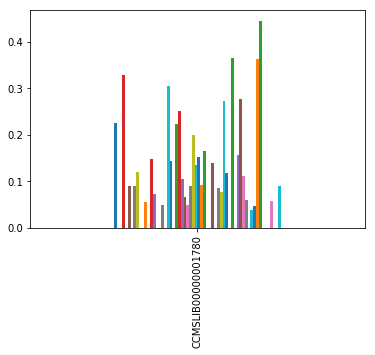

In [42]:
%matplotlib inline

testing3_df[testing3_df.label == "GCF3"].plot.bar(legend=None)

In [43]:
len(affinity_bgcs),len(affinity_df)

(5895, 4489)

In [44]:
filt_aff_bgcs = []

for item in affinity_bgcs:
    if not item.startswith("BGC"):
        filt_aff_bgcs.append(item)

len(filt_aff_bgcs)

4489

In [45]:
affinity_df["bgc"] = filt_aff_bgcs

affinity_df

,1A2,1A3,1A7,1B1,1B6,1C2,1C3,1C4,1D4,1D5,...,NHIA01,NHII01,NHIK01,NHIL01,NHJC01,NHJU01,NHKA01,PALPB,label,bgc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,GCF217,AJTX02_004
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,GCF217,ANKN01_003
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,GCF216,AJTX02_005
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,GCF216,ANKN01_002
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,GCF215,ANKN01_001
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,GCF215,AJTX02_003
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,GCF214,MTAX01_001
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,GCF214,MTAW01_010
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,GCF214,AGCR01_019
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,GCF210,3B2_010


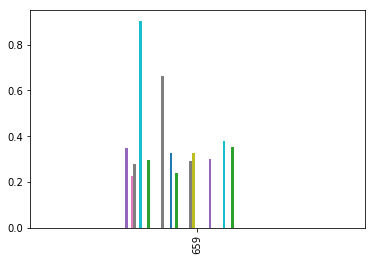

In [46]:
curacin_subset = affinity_df[affinity_df.bgc == "AEPQ01_030"]

curacin_subset = curacin_subset[genome_list]

curacin_subset.plot.bar(legend=False)